In [ ]:
!pip install uproot
!pip install uproot_methods
import uproot
from uproot_methods.classes import TLorentzVector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Caricamento dei file

In [ ]:
# carico i file
filename="segnale1.root" # segnale dileptonico
segnale = uproot.open(filename)

filename2="fondo_1.root" # fondo
fondo = uproot.open(filename2)

# accedo alle colonne
print(segnale["trees/events"].keys())

['muons_size', 'muons_pt', 'muons_eta', 'muons_phi', 'muons_e', 'muons_charge', 'muons_chi2', 'muons_mctruthmatch', 'muons_minDR', 'muons_dB', 'muons_dz', 'muons_reliso', 'muons_isLooseMuon', 'muons_isTightMuon', 'muons_nmatchstat', 'muons_nmuonhits', 'muons_npixhits', 'muons_nlaywithmeas', 'electrons_size', 'electrons_pt', 'electrons_eta', 'electrons_phi', 'electrons_e', 'electrons_mctruthmatch', 'electrons_minDR', 'electrons_isTightElectron', 'electrons_reliso', 'electrons_hOverE', 'electrons_dB', 'electrons_dz', 'electrons_dEtaIn', 'electrons_dPhiIn', 'electrons_ninner', 'electrons_sigmaieie', 'electrons_ooemoop', 'met_pt', 'met_phi', 'jets_size', 'jets_pt', 'jets_eta', 'jets_phi', 'jets_e', 'muons_c', 'genlep_size', 'genlep_pt', 'genlep_eta', 'genlep_phi', 'genlep_e', 'genlep_id', 'electrons_charge']


In [ ]:
# fondo contro segnale
# contro segnale Z
# massa della Z
# feature met energia mancante -> es. neutrini
# nella zeta avrò met minore perché i neutrini trasportano meno energia
# allenare contro il fondo

In [ ]:
# trasformo in pandas dataframe i dati

# segnale
np_segnale = (segnale["trees/events"].arrays(segnale["trees/events"].keys(),library="np"))
df_segnale = pd.DataFrame(np_segnale)

# fondo
np_fondo = (fondo["trees/events"].arrays(fondo["trees/events"].keys(),library="np"))
df_fondo = pd.DataFrame(np_fondo)

In [ ]:
print(df_segnale.shape)
df_fondo.shape

(50000, 50)


(50000, 50)

In [ ]:
def drop_size(df):
  for i in range(df.shape[0]):
    if df['jets_size'][i] < df['electrons_size'][i] or df['jets_size'][i] < df['electrons_size'][i]:
      # print(i)
      df = df.drop(i, axis=0)
  df.index=list(range(df.shape[0]))
  return df

df_fondo = drop_size(df_fondo)
df_segnale = drop_size(df_segnale)

In [ ]:
def drop_rows(df):
  drop_rows = []
  for i in range(df.shape[0]):
    if df['jets_pt'][i].size==0 and df['muons_pt'][i].size==0 and df['electrons_pt'][i].size==0:
      drop_rows.append(i)
  return drop_rows

In [ ]:
drop_list_segnale = drop_rows(df_segnale)
drop_list_fondo = drop_rows(df_fondo)

df_segnale = df_segnale.drop(drop_list_segnale, axis=0)
df_fondo = df_fondo.drop(drop_list_fondo, axis=0)

print(df_segnale.shape)
df_fondo.shape

(49976, 50)


(42306, 50)

In [ ]:
df_fondo = df_fondo[:5000]
df_segnale = df_segnale[:5000]

In [ ]:
df_fondo.index=list(range(5000))
df_segnale.index=list(range(5000))

# Preprocessing dei dati


In [ ]:
def filter_df_by_name(dataframe,particle):
  '''restituisce dataframe con le colonne relative alla particella selezionata,
  il parametro particle da inserire deve essere una stringa'''
  '''per esempio "electrons" oppure "muons"'''
  list_feat_elect=[]
  for i in list(dataframe.columns):
    if particle in i:
        list_feat_elect.append(i)
  df_filtered=dataframe[list_feat_elect]
  return df_filtered

In [ ]:
def is_null(df):
    '''
    Check and count if there are null value in a whole dataframe, column by column
    '''
    col=list(df.columns)
    counting = []
    for i in col:
        count = 0
        for j in df[i]:
            if type(j)==int:
              count = 'int'
              break
            if len(j)==0:
                count += 1
        counting.append(count)
    return dict(zip(col, counting))

print('fondo: ', is_null(df_fondo))
print('segnale: ', is_null(df_segnale))


fondo:  {'muons_size': 'int', 'muons_pt': 3376, 'muons_eta': 3376, 'muons_phi': 3376, 'muons_e': 3376, 'muons_charge': 3376, 'muons_chi2': 3376, 'muons_mctruthmatch': 3376, 'muons_minDR': 3376, 'muons_dB': 3376, 'muons_dz': 3376, 'muons_reliso': 3376, 'muons_isLooseMuon': 3376, 'muons_isTightMuon': 3376, 'muons_nmatchstat': 5000, 'muons_nmuonhits': 3376, 'muons_npixhits': 3376, 'muons_nlaywithmeas': 3376, 'electrons_size': 'int', 'electrons_pt': 3212, 'electrons_eta': 3212, 'electrons_phi': 3212, 'electrons_e': 3212, 'electrons_mctruthmatch': 3212, 'electrons_minDR': 3212, 'electrons_isTightElectron': 3212, 'electrons_reliso': 3212, 'electrons_hOverE': 3212, 'electrons_dB': 3212, 'electrons_dz': 3212, 'electrons_dEtaIn': 3212, 'electrons_dPhiIn': 3212, 'electrons_ninner': 3212, 'electrons_sigmaieie': 3212, 'electrons_ooemoop': 3212, 'met_pt': 0, 'met_phi': 0, 'jets_size': 'int', 'jets_pt': 0, 'jets_eta': 0, 'jets_phi': 0, 'jets_e': 0, 'muons_c': 5000, 'genlep_size': 'int', 'genlep_pt':

In [ ]:
# droppiamo le colonne che hanno nel nome 'genlep' perché vuote
def drop_genlep(dataframe):
    list_feat_del=[]
    for column in list(dataframe.columns):
        if "genlep" in column:
            list_feat_del.append(column)

    dataframe=dataframe.drop(columns=list_feat_del)
    return dataframe

print(df_segnale.shape)
df_segnale = drop_genlep(df_segnale)
df_fondo = drop_genlep(df_fondo)
df_segnale.shape

(5000, 50)


(5000, 44)

In [ ]:
def n_particles(df):
# Vogliamo sapere per ogni evento quante particelle ci sono
# in modo da creare una lista con un secondo indice
  col = df.columns
  index_2 = []
  col_index = []
  list_dict = []
  for i in col:
    index_2 = []
    for j in range(df.shape[0]):
      if type(df[i][j])==int:
          break
      count = 1
      if (df[i][j].size==1 or df[i][j].size==0):
        count = 1
        index_2.append(count)
      else:
        for k in range(1,df[i][j].size+1):
          count = k
          index_2.append(count)
    #col_index è una lista (ciclata su tutte le colonne) del tipo:
    #col_index[41]=[1,2,3,1,2,1,...]
    #cioè la colonna 41 ha come prima riga un array di dimensione 3,
    #come seconda uno di dimensione 2,ecc..

    col_index.append(index_2)

    #dic è un dizionario che associa ad ogni colonna il numero totale di
    #particelle coinvolte
    dic = dict(zip(df.columns, [len(col_index[i]) for i in range(len(col_index))] ))
    # dizionario che restituisce come chiave il nome della feature
    # e come valore la size della colonna corrispondente
  return dic,col_index

In [ ]:
def indexing_columns(df, feature_name, size, col_index):
  '''
  Restituisce una lista di indici che segnalano l'evento di riferimento
  contando tutte le particelle (o suoi attributi) presenti in una determinata colonna
  '''
  # prendo l'indice corrispondente a quella colonna per lavorare su col_index
  index_col = df.columns.get_loc(feature_name)
  ind = []
  evento = 0
  for i in range(size):
    # condizione sull'ultimo valore: se è 1 bisogna incrementare la variabile evento
    if i==(size-1):
      ind.append(evento)
      break
    ind.append(evento)
    # condizione che si verifica quando si cambia evento
    # esempio: [1,2,3,1,2,1] -> questa lista contiene 3 eventi:
    # il primo è composto da tre slot particelle, il secondo da due e l'ultimo da uno
    if col_index[index_col][i] >= col_index[index_col][i+1]:
      evento = evento + 1
  return ind

In [ ]:
# non ci interessano tutte le colonne
features = ['muons_pt', 'muons_e', 'electrons_pt', 'electrons_e', 'electrons_isTightElectron', 'muons_isTightMuon', 'jets_pt', 'jets_e', 'met_pt', 'met_phi', 'muons_eta', 'muons_phi', 'electrons_eta', 'electrons_phi', 'jets_eta', 'jets_phi']

In [ ]:
# vogliamo creare l'indice 1, quello che ci dà informazione su che evento stiamo guardando,
# dunque prendo nome e size della colonna con size massima (solitamente è quella che fa riferimento
# agli attributi dei jet -MA NON LA SIZE-)
import operator

# prendiamo solo le colonne selezionate
df = df_segnale[features] # per il segnale
df_f = df_fondo[features] # per il fondo

# genero il dizionario delle size e l'indice che conta le particelle per evento
dic, col_index = n_particles(df) # per il segnale
dic_fondo, col_index_fondo = n_particles(df_f) # per il fondo

# size colonna di dimensione massima (solitamente è quella dei jet)
max_value = max(dic.values()) # per il segnale
max_value_fondo = max(dic_fondo.values()) # per il fondo

# nome corrispondente alla colonna di size massima
max_key = max(dic.items(), key=operator.itemgetter(1))[0] # per il segnale
max_key_fondo = max(dic_fondo.items(), key=operator.itemgetter(1))[0] # per il fondo

# genero l'indice degli eventi
ind_max_list = indexing_columns(df, max_key, max_value, col_index)
ind_max_list_fondo = indexing_columns(df_f, max_key_fondo, max_value_fondo, col_index_fondo)

In [ ]:

# generiamo il nuovo array di dati in cui tutte le colonne avranno size pari
# alla dimensione della colonna di size massima, riempiendo gli 'spazi vuoti' con 'null_var',
# altrimenti -10 (per le grandezze eta e phi)

def new_array_stepone(df, ind_max_list, dic, col_index):
  new_df_array = []
  new_df_col = []
  col = df.columns

  for i in col:
    new_df_col = []
    # if 'eta' in i or 'phi' in i:
    if 'isTight' in i:
      null_var = 0
    else:
      null_var = -10

    for j in range(df.shape[0]):

      # questa condizione serve nel caso ci sia una colonna di int
      if type(df[i][j])==int or type(df[i][j])==np.int32:
          break

      # calcolo la differenza di particelle tra quelle presenti
      # nella colonna i-esima e la colonna con la size massima
      diff = ind_max_list.count(j) - indexing_columns(df, i, dic[i], col_index).count(j)

      if df[i][j].size==0:
        # nel caso in cui ci sia un vettore vuoto aggiungiamo null_var
        new_df_col.append(null_var)
        for w in range(diff): # riempio gli slot vuoti
          new_df_col.append(null_var)

      else:

        for k in range(df[i][j].size):
          # nel caso in cui il vettore abbia dei valori, li aggiungo
          new_df_col.append(df[i][j].tolist()[k])
        for w in range(diff): # riempio gli slot vuoti
          new_df_col.append(null_var)

    new_df_array.append(new_df_col)

  return new_df_array

In [ ]:
new_df_array = new_array_stepone(df, ind_max_list, dic, col_index)
new_df_array_fondo = new_array_stepone(df_f, ind_max_list_fondo, dic_fondo, col_index_fondo)

In [ ]:
# 'muons_pt', 'muons_e', 'electrons_pt', 'electrons_e', 'electrons_isTightElectron', 'muons_isTightMuon', 'jets_pt', 'jets_e', 'met_pt', 'met_phi', 'muons_eta', 'muons_phi', 'electrons_eta', 'electrons_phi', 'jets_eta', 'jets_phi'

In [ ]:
# for i in range(len(new_df_array_fondo)):
#   print(len(new_df_array_fondo[i]))

# print(new_df_array_fondo[1])


In [ ]:
dic_df = dict(zip(features, new_df_array))
dic_df_f = dict(zip(features, new_df_array_fondo))

# trasformo il vettore creato in pandas dataframe, con indice relativo all'evento
new_df_segnale = pd.DataFrame(data=dic_df, index=ind_max_list)
new_df_fondo = pd.DataFrame(data=dic_df_f, index=ind_max_list_fondo)

# Padding

In [ ]:
# controllo il numero di eventi massimo
def check_max_event(new_df, max_key):
  n_partic_per_event = []
  for i in range(max(list(new_df.index))+1):
    if type(new_df[max_key].loc[i])==np.float64: # caso in cui abbiamo un unico jet (non posso ciclare su un unico valore)
      n_partic_per_event.append(1)
    else:
      n_partic_per_event.append(new_df[max_key].loc[i].count())

  return max(n_partic_per_event)

In [ ]:
# computo il numero di slot massimo per evento presente nel dataframe segnale e fondo
max_event_segnale = check_max_event(new_df_segnale, max_key)
max_event_fondo = check_max_event(new_df_fondo, max_key_fondo)

In [ ]:
# dovranno essere concatenati, quindi scegliamo il maggiore tra i due
max_n_slot = max([max_event_segnale, max_event_fondo])
print(max_n_slot)

19


In [ ]:
def index_padding(ind_max_list, max_event):
  '''
  creo la nuova lista di indici per rendere ogni evento di size
  pari alla dimensione massima di un evento
  '''
  ind_list = []
  for i in range(len(ind_max_list)):
    if i==(len(ind_max_list)-1): # condizione sull'ultimo valore
      ind_list.append(ind_max_list[i])
      diff = max_event - ind_list.count(ind_max_list[i])
      for j in range(diff):
        ind_list.append(ind_max_list[i])
      break
    ind_list.append(ind_max_list[i])
    diff = max_event - ind_list.count(ind_max_list[i])
    if diff<0: # volevo essere simpatica
      print(ind_max_list[i])
      print('Houston, we have a problem!')
    if ind_max_list[i+1] > ind_max_list[i]:
      for j in range(diff):
        ind_list.append(ind_max_list[i])
  return ind_list

# ind_list è quindi l'indice del dataframe definitivo dopo aver fatto il padding

In [ ]:
# unrolling
ind_list = index_padding(ind_max_list, max_n_slot)
ind_list_fondo = index_padding(ind_max_list_fondo, max_n_slot)

In [ ]:
def array_colonne_def(col, new_df, max_event):
  colonne_definitive = [] # finalmente

  for i in col:
    # if 'eta' in i or 'phi' in i:
    if 'isTight' in i:
      null_var = 0
    else:
      null_var = -10

    col_def = []

    for j in range(max(list(new_df.index))+1):

      if type(new_df[i].loc[j])==np.float64: # nel caso ci sia un unico jet
        diff = max_event - 1
        col_def.append(new_df[i].loc[j])
        for w in range(diff):
            col_def.append(null_var)

      else:

        diff = max_event - len(list(new_df[i].loc[j]))
        for k in list(new_df[i].loc[j]):
          col_def.append(k)
        for w in range(diff):
          col_def.append(null_var)

    colonne_definitive.append(col_def)
  return colonne_definitive


In [ ]:
# colonne_definitive è il dataframe che conta per ogni evento
# numero di event_max_size slot particelle

colonne_definitive = array_colonne_def(features, new_df_segnale, max_n_slot)
colonne_definitive_fondo = array_colonne_def(features, new_df_fondo, max_n_slot)

In [ ]:
dic_def_df = dict(zip(features, colonne_definitive))
dic_def_df_f = dict(zip(features, colonne_definitive_fondo))

# l'indice per il fondo deve essere diverso, perché
# il df fondo deve essere concatenato con df segnale
index_fondo = np.array(ind_list_fondo) + 5000    # ci sono 10000 eventi per df

# lo trasformo in pandas dataframe
def_df_segnale = pd.DataFrame(data=dic_def_df, index=ind_list)
def_df_fondo = pd.DataFrame(data=dic_def_df_f, index=index_fondo)

In [ ]:
# magari servirà più in là, boh
v1 = TLorentzVector.TLorentzVector.from_ptetaphie(pt=40.124088,	eta= -0.154926,	phi=-2.44714, energy=40.606724)
v2 = TLorentzVector.TLorentzVector.from_ptetaphie(pt=118.894325,	eta=-1.415037, 	phi=1.565296, energy=259.1633)

In [ ]:
def_df_segnale['muons_isTightMuon']

0       0.0
0       0.0
0       0.0
0       0.0
0       0.0
       ... 
4999    0.0
4999    0.0
4999    0.0
4999    0.0
4999    0.0
Name: muons_isTightMuon, Length: 95000, dtype: float64

In [ ]:
def select_events(df):
  '''
  questa funzione aggiunge al dataframe la label binaria 'top_label',
  essa vale 1 quando:
  - ci sono due elettroni 'isTight';
  - ci sono due muoni 'isTight';
  - c'è un elettrone e un muone, entrambi 'isTight'.
  altrimenti vale 0.
  'num_events' = 2 perché prendiamo almeno 2 leptoni per evento
  '''
  label=[]
  for i in range(df.index[0], max(df.index)+1):
    # se i leptoni sono isolati
    if df.loc[i]['electrons_isTightElectron'].sum()+df.loc[i]['muons_isTightMuon'].sum()>=2:
      for i in range(max_n_slot):
        # label segnale
        label.append(1)
    else:
      for i in range(max_n_slot):
        # label fondo
        label.append(0)

  df['top_label'] = label
  # df = df.query('top_label==1')
  return df


In [ ]:
# creo il dataframe con la label
df_stepone = select_events(def_df_segnale)
df_stepone_fondo = select_events(def_df_fondo)

In [ ]:
df_stepone.groupby('top_label').count()

,muons_pt,muons_e,electrons_pt,electrons_e,electrons_isTightElectron,muons_isTightMuon,jets_pt,jets_e,met_pt,met_phi,muons_eta,muons_phi,electrons_eta,electrons_phi,jets_eta,jets_phi
top_label,,,,,,,,,,,,,,,,
0,77083,77083,77083,77083,77083,77083,77083,77083,77083,77083,77083,77083,77083,77083,77083,77083
1,17917,17917,17917,17917,17917,17917,17917,17917,17917,17917,17917,17917,17917,17917,17917,17917


In [ ]:
df_stepone_fondo.groupby('top_label').count()

,muons_pt,muons_e,electrons_pt,electrons_e,electrons_isTightElectron,muons_isTightMuon,jets_pt,jets_e,met_pt,met_phi,muons_eta,muons_phi,electrons_eta,electrons_phi,jets_eta,jets_phi
top_label,,,,,,,,,,,,,,,,
0,74461,74461,74461,74461,74461,74461,74461,74461,74461,74461,74461,74461,74461,74461,74461,74461
1,20539,20539,20539,20539,20539,20539,20539,20539,20539,20539,20539,20539,20539,20539,20539,20539


In [ ]:
df_stepone = df_stepone.query('top_label==1')
df_stepone_fondo = df_stepone_fondo.query('top_label==1')

In [ ]:
def target(df_segnale, df_fondo):
  '''
  Questa funzione prende in input i dataframe di segnale e fondo, crea la label
  per distinguerli e poi fa il merge dei due.
  '''
  df_segnale['target'] = np.ones((1,df_segnale.shape[0]))[0] # lab = 1
  df_fondo['target'] = np.ones((1,df_fondo.shape[0]))[0]*0 # lab = 0

  tot_df = pd.concat([df_segnale, df_fondo], axis=0, ignore_index=False)
  # il dataframe che ne risulta preserva gli indici di entrambi che segnalano quindi 2k eventi
  return tot_df

In [ ]:
tot_df = target(df_stepone, df_stepone_fondo)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
def indice_ridotto(df):
  indice_ridotto = []
  for i in range(int(df.shape[0]/max_n_slot)):
    for j in range(max_n_slot):
      indice_ridotto.append(i)
  df.index = indice_ridotto
  return df

In [ ]:
tot_df = indice_ridotto(tot_df)

# devo fare lo shuffle sugli eventi, non sulle righe.
# Quindi facciamo lo shuffle sugli indici

index_list = list(np.array(list(range(int(tot_df.shape[0]/max_n_slot))))) # creo la lista degli indici
np.random.shuffle(index_list) # shuffle non ritorna niente, agisce su index_list

tot_df = tot_df.loc[index_list]
#.sort_index()

# tot_df.to_csv('tot_df_7.csv')

In [ ]:
tot_df.head(50)

,muons_pt,muons_e,electrons_pt,electrons_e,electrons_isTightElectron,muons_isTightMuon,jets_pt,jets_e,met_pt,met_phi,muons_eta,muons_phi,electrons_eta,electrons_phi,jets_eta,jets_phi,top_label,target
1051,27.620361,81.199272,-10.000000,-10.000000,0.0,1.0,27.620361,81.199272,3.806244,-2.233869,1.741230,-1.789123,-10.000000,-10.000000,1.741230,-1.789123,1,0.0
1051,23.156866,27.434654,-10.000000,-10.000000,0.0,1.0,23.156866,27.434654,-10.000000,-10.000000,-0.598831,1.321169,-10.000000,-10.000000,-0.598831,1.321169,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0
1051,-10.000000,-10.000000,-10.000000,-10.000000,0.0,0.0,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,1,0.0


# LSTM

In [ ]:
tot_df = pd.read_csv('tot_df_2.csv')
# tot_df['Unnamed: 0']
tot_df.index = tot_df['Unnamed: 0']
tot_df = tot_df.drop(['Unnamed: 0'], axis=1)

In [ ]:
import keras
from keras.layers.core import Activation
import keras.backend as K
from keras.layers import Dense, LSTM, Dropout, Masking, Bidirectional
from keras.models import Sequential, load_model, Model, Input
from tensorflow.keras.optimizers import Adam,SGD
import tensorflow.keras.losses as loss
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint



In [ ]:
def shape_sequence(arr, step):
  '''
  questa funzione prende in input il dataset (arr),
  il numero massimo di particelle in un evento (step)
  e l'indice da cui comincia la ricerca (start = 0)
  '''
  #track=[]
  start = 0
  out = list()
  for i in range(start, arr.shape[0], max_n_slot):
      low_lim = i
      up_lim = low_lim + step
      out.append(arr[low_lim: up_lim])
      # print(arr[low_lim: up_lim])

      if up_lim == arr.shape[0]: # condizione sull'ultimo evento
        break


  out_seq = np.array(out)

  return out_seq

In [ ]:
# trasformo il dataframe in lista
x_col = list(tot_df.columns)

# rimuovo la colonna della variabile target
x_col.remove('target')
x_col.remove('electrons_isTightElectron')
x_col.remove('muons_isTightMuon')
# x_col.remove('met_pt')
# x_col.remove('met_phi')
# x_col.remove('jets_pt')
# x_col.remove('jets_eta')
# x_col.remove('jets_phi')

x_col.remove('top_label')
X = tot_df[x_col].values

# definisco la colonna della variabile target
y = tot_df['target'].values

# from sklearn.preprocessing import StandardScaler
# std = StandardScaler()
# X = std.fit_transform(X)

# preprocessing per LSTM
X= shape_sequence(X, 4)
y= shape_sequence(y, 4)


In [ ]:
# splitto il dataset in training e test set

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

In [ ]:
def create_model(X_train, y_train):

  shape = X_train.shape[1] # dimensione dell'evento
  feat_length = X_train.shape[2] # numero di features
  numberOfLSTMunits = 1

  input = Input(shape=(shape, feat_length))
  state_h_0 = LSTM(shape*3, return_sequences=True) (input)
  # state_h = LSTM(shape*2, return_sequences=True) (state_h_0)
  state_h = Dense(shape, activation='tanh') (state_h_0)
  state_h_2 = LSTM(numberOfLSTMunits) (state_h)
  # state_h_3 = Dense(1, activation='relu') (state_h_2)
  model = Model(inputs=input, outputs=state_h_2)
  model.summary()
  opt=SGD()
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

model_666 = create_model(X_train, y_train)
# mcp_save = ModelCheckpoint('/content', save_best_only=True, monitor='accuracy', mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1e-7, verbose=1)
history = model_666.fit(X_train, y_train, epochs=15, verbose=2, validation_data=(X_test, y_test), callbacks=[reduce_lr])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 14)]           0         
                                                                 
 lstm (LSTM)                 (None, 4, 12)             1296      
                                                                 
 dense (Dense)               (None, 4, 4)              52        
                                                                 
 lstm_1 (LSTM)               (None, 1)                 24        
                                                                 
Total params: 1,372
Trainable params: 1,372
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
51/51 - 5s - loss: 0.5410 - accuracy: 0.6325 - val_loss: 0.4425 - val_accuracy: 0.8494 - lr: 0.0100 - 5s/epoch - 105ms/step
Epoch 2/15
51/51 - 0s - loss: 0.4025 - accuracy: 0.8826 

In [ ]:
def reduce_Y(y):
  one_y = []
  for i in y:
    one_y.append(i[0])
  return np.array(one_y)

In [ ]:
def count_label(d_set):
  count_0 = 0
  count_1 = 0
  for i in d_set:
    if i[0]==0:
      count_0 = count_0 + 1
    else:
      count_1 = count_1 + 1
  print('fondo: ', count_0)
  print('segnale ', count_1)

In [ ]:
# shape = X_train.shape[1] # dimensione dell'evento
# feat_length = X_train.shape[2] # numero di features

# model_1 = Sequential()
# # model_1.add(Masking(mask_value=-10, input_shape=(shape, feat_length)))
# model_1.add(model)
# model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=1e-7, verbose=1)
# # mcp_save = ModelCheckpoint('/content', save_best_only=True, monitor='accuracy', mode='min')
# history_1 = model.fit(X_train, y_train, epochs=15, verbose=2, validation_data=(X_test, y_test),steps_per_epoch=15, callbacks=[reduce_lr])


In [ ]:
y_test = reduce_Y(y_test)
y_train = reduce_Y(y_train)

In [ ]:
y_pred = model_666.predict(X_test)

In [ ]:
# Definizione fondo e segnale

d0 = model_666.predict(X_train[np.where(y_train>0.5)])
d1 = model_666.predict(X_train[np.where(y_train<0.5)])

d2 = model_666.predict(X_test[np.where(y_test>0.5)])
d3 = model_666.predict(X_test[np.where(y_test<0.5)])


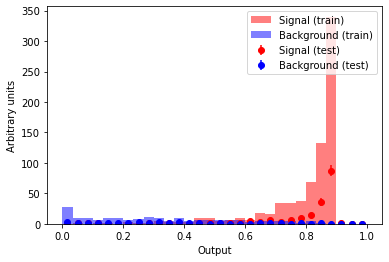

In [ ]:
# Plot fondo e segnale
fig, ax = plt.subplots()
ax.hist(d0, color='r', alpha=0.5, range=(0,1), bins=30, histtype='stepfilled', label='Signal (t\
rain)')
ax.hist(d1, color='b', alpha=0.5, range=(0,1), bins=30, histtype='stepfilled', label='Backgroun\
d (train)')
hist, bins = np.histogram(d2, bins=30, range=(0,1))
scale = len(d2) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Signal (test)')
hist, bins = np.histogram(d3, bins=30, range=(0,1))
scale = len(d3) / sum(hist)
err = np.sqrt(hist * scale) / scale
ax.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Background (test)')
ax.set_xlabel("Output")
ax.set_ylabel("Arbitrary units")
# ax.set_title()
ax.legend(loc='best')

In [ ]:
y_pred_ = []
for i in list(y_pred):
  if i<0.5 and i>-0.2:
    y_pred_.append(0)
  else:
    y_pred_.append(1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix=confusion_matrix(y_test, y_pred_)

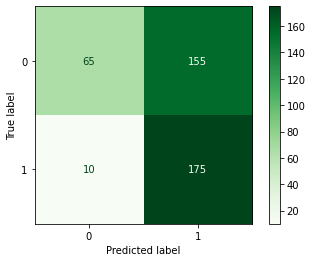

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

disp.plot(cmap=plt.cm.Greens)
plt.show()

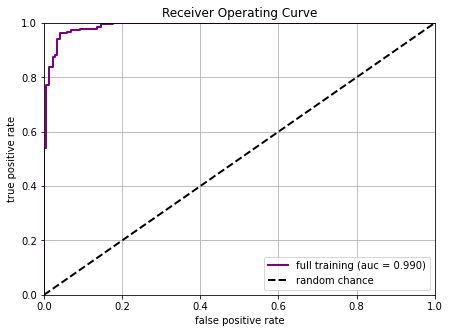

In [ ]:
from sklearn.metrics import roc_curve, auc

# Roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

# Roc plot
fig_roc, ax_roc = plt.subplots(figsize=(7, 5))
ax_roc.plot(fpr, tpr, lw=2, color='purple',label='full training (auc = %.3f)' % (roc_auc))
ax_roc.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax_roc.set_xlim([0, 1.0])
ax_roc.set_ylim([0, 1.0])
ax_roc.set_xlabel('false positive rate')
ax_roc.set_ylabel('true positive rate')
ax_roc.set_title('Receiver Operating Curve')
ax_roc.grid(True)
ax_roc.legend()


In [ ]:
y_pred_1 = []
for i in y_pred:
  if i<0.4 and i>-0.1:
    y_pred_1.append(0)
  else:
    y_pred_1.append(1)


In [ ]:
def accuracy_between_lists(listtrue,listpred):
  count=0
  for i in range(len(listtrue)):
    if listtrue[i]==listpred[i]:
      count=count+1
  score=count/len(listtrue)
  return score

# accuracy_between_lists(y_test_1, y_pred)

In [ ]:
def round_list(list):
  for i in range(len(list)):
    if list[i]>=0.5:
      list[i]=1.0
    else:
      list[i]=0.0
  return list

In [ ]:
# y_pred_model1=model1.predict(X_test)
# y_pred_model1

In [ ]:
scores = model_666.evaluate(X_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

13/13 - 1s - loss: 0.1984 - accuracy: 0.9531 - 937ms/epoch - 72ms/step
Accuracy: 95.31%


In [ ]:
def lstm_test_evaluation_graphs(history):
    # summarize history for accuracy
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_accuracy.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

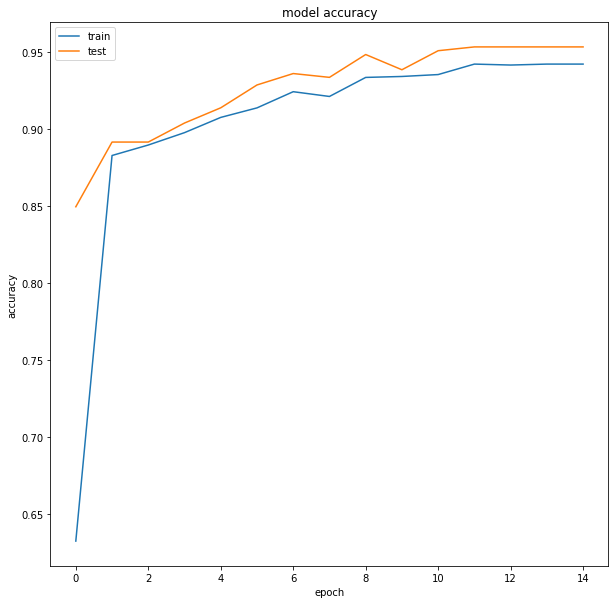

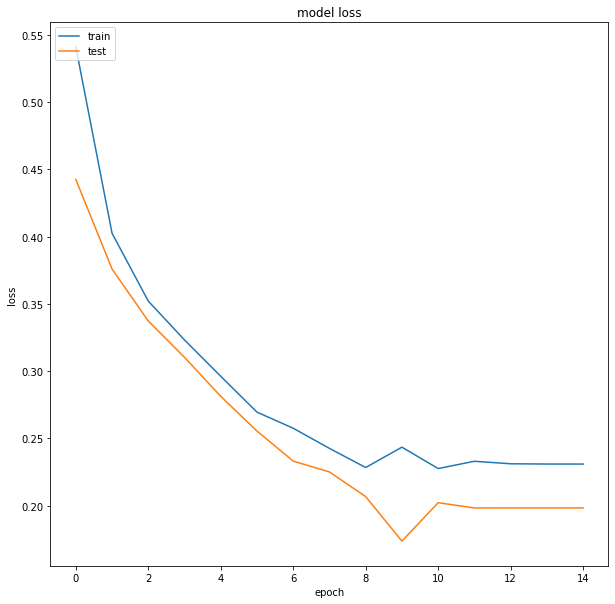

In [ ]:
lstm_test_evaluation_graphs(history)

# **Genetic Algorithm**: ☯

In [ ]:
!pip install deap
from deap import base
from deap import creator
from deap import tools
import random

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Individual creation

In [ ]:

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox=base.Toolbox()
toolbox.register("attr", random.randint, 0, 3)


toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr,7)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Fitness function


In [ ]:
# global tot_df

def EvaluateFeatures(individual):
  tot_df = pd.read_csv('tot_df_2.csv')
  # tot_df['Unnamed: 0']
  tot_df.index = tot_df['Unnamed: 0']
  tot_df = tot_df.drop(['Unnamed: 0'], axis=1)
  #shuffle sul dataframe
  index_list = list(np.array(list(range(int(tot_df.shape[0]/max_n_slot))))) # creo la lista degli indici
  np.random.shuffle(index_list) # shuffle non ritorna niente, agisce su index_list

  tot_df = tot_df.loc[index_list]

  x_col = list(tot_df.columns)

  # rimuovo la colonna della variabile target
  x_col.remove('target')
  x_col.remove('electrons_isTightElectron')
  x_col.remove('muons_isTightMuon')
  x_col.remove('top_label')
  X = tot_df[x_col].values

  # definisco la colonna della variabile target
  y = tot_df['target'].values

  # preprocessing per LSTM
  X= shape_sequence(X, 4)
  y= shape_sequence(y, 4)

  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

  model1=create_model(X_train,y_train)

  shape=X_train.shape[1]
  feat_length=X_train.shape[2]

#l'individuo sarà una lista di 6 componenti fatta di numeri random da 0 a 4
#per esempio l'individuo: [0,0,0,0,0,0] corrisponde a scegliere
#[1,sigmoid,sigmoid,LSTM(feat_length),0,5]

#la struttura generale dell'individuo è quindi:
#[n_layers,activation,rec_activation,layers,semifinal_layer,number_epochs]
  lista_of_activation=['sigmoid','tanh','softmax','relu']  #individual[0]
  lista_first_condition=[0,0,1,1] #individual[1]
  lista_second_condition=[0,1,2,3] #individual[2]
  lista_condizione_finale=[0,0,1,1] #individual[3]
  lista_interi_m=[1,2,3,4] #individual[4]
  lista_interi_n=[1,2,3,4] #individual[5]
  list_number_of_epochs=[10,15,20,25] #individual[6]

  input = Input(shape=(shape, feat_length))
  if lista_first_condition[individual[1]] == 1:
    if lista_second_condition[individual[2]]==0:
      state_h_0 = LSTM(shape*lista_interi_m[individual[4]], return_sequences=True) (input)
      state_h = LSTM(shape*lista_interi_n[individual[5]], return_sequences=True) (state_h_0)
    elif lista_second_condition[individual[2]]==1:
      state_h_0 = Dense(shape*lista_interi_m[individual[4]], activation=lista_of_activation[individual[0]]) (input)
      state_h = Dense(shape*lista_interi_n[individual[5]], activation=lista_of_activation[individual[0]]) (state_h_0)
    elif lista_second_condition[individual[2]]==2:
      state_h_0 = LSTM(shape*lista_interi_m[individual[4]], return_sequences=True) (input)
      state_h = Dense(shape*lista_interi_n[individual[5]], activation=lista_of_activation[individual[0]]) (state_h_0)
    elif lista_second_condition[individual[2]]==3:
      state_h_0 = Dense(shape*lista_interi_m[individual[4]], activation=lista_of_activation[individual[0]]) (input)
      state_h = LSTM(shape*lista_interi_m[individual[4]], return_sequences=True) (state_h_0)
  else:
    if lista_condizione_finale[individual[3]]==0:
      state_h = LSTM(shape*lista_interi_n[individual[5]], return_sequences=True) (input)
    else:
      state_h = Dense(shape*lista_interi_n[individual[5]], activation=lista_of_activation[individual[0]]) (input)

  state_h_2 = LSTM(1) (state_h)
  model = Model(inputs=input, outputs=state_h_2)

  reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1e-7, verbose=2)
  opt=SGD(lr=0.01)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

  model.fit(X_train, y_train, epochs=list_number_of_epochs[individual[5]], validation_data=(X_test, y_test), callbacks=[reduce_lr], verbose=2)
  score = model.evaluate(X_test, y_test)
  return (score[1],)


In [ ]:
toolbox.register("evaluate", EvaluateFeatures)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt,low=0,up=3, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook=tools.Logbook()
random.seed(69)

Start of evolution
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 14)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 12)             1296      
                                                                 
 dense_1 (Dense)             (None, 4, 4)              52        
                                                                 
 lstm_3 (LSTM)               (None, 1)                 24        
                                                                 
Total params: 1,372
Trainable params: 1,372
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Output streaming troncato alle ultime 5000 righe.
Epoch 24/25
45/45 - 0s - loss: 0.5903 - accuracy: 0.5565 - val_loss: 0.5937 - val_accuracy: 0.5691 - lr: 1.0000e-07 - 377ms/epoch - 8ms/step
Epoch 25/25
45/45 - 0s - loss: 0.5903 - accuracy: 0.5565 - val_loss: 0.5937 - val_accuracy: 0.5691 - lr: 1.0000e-07 - 385ms/epoch - 9ms/step
19/19 [==============================] - 0s 4ms/step - loss: 0.5937 - accuracy: 0.5691
Model: "model_189"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_190 (InputLayer)      [(None, 4, 14)]           0         
                                                                 
 lstm_385 (LSTM)             (None, 4, 12)             1296      
                                                                 
 dense_137 (Dense)           (None, 4, 4)              52        
                                                                 
 lstm_386 (LSTM)             (None

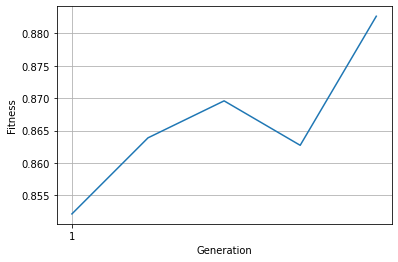

In [ ]:

random.seed(69)
pop = toolbox.population(n=30)
#print(pop)
CXPB, MUTPB = 0.9, 0.3

print("Start of evolution")

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, pop))

print(type(fitnesses))

for ind, fit in zip(pop,fitnesses):
    ind.fitness.values = fit

print("  Evaluated %i individuals" % len(pop))

# Extracting all the fitnesses of
fits = [ind.fitness.values[0] for ind in pop]      # facciamo una lista con le fitnesses degli individui, ind.fitness.values
                                                    # è un vettore (?) composto in questo caso di una sola entrata,
                                                    # di cui passiamo il valore

# Variable keeping track of the number of generations
g = 0

# Begin the evolution
while max(fits) < 100 and g < 5:
    # A new generation
    g = g + 1
    print("-- Generation %i --" % g)

    # Select the next generation individuals
    offspring = toolbox.select(pop, len(pop))        # scrivere direttamente 300 va bene lo stesso, sembra. len(pop) è la grandezza della mating pool
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))      # inutile?



    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):  # offspring[::2] è la lista offspring valutata un elemento
                                                                  # sì e uno no a partire dal primo (di posto 0),
                                                                  # offspring[1::2] è la stessa cosa ma partendo dal secondo
                                                                  # (di posto 1)

        # cross two individuals with probability CXPB
        if random.random() < CXPB:
            toolbox.mate(child1, child2)

            # fitness values of the children
            # must be recalculated later
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:

        # mutate an individual with probability MUTPB
        if random.random() < MUTPB:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness                  # "ind al variare di ind in offspring se il valore di fitness non è valido"
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]   # creiamo una lista con gli individui alterati
    fitnesses = map(toolbox.evaluate, invalid_ind)                      # da crossover e/o mutazioni, cui abbiamo cancellato
    for ind, fit in zip(invalid_ind, fitnesses):                        # la fitness precedentemente. Gli riassegniamo
        ind.fitness.values = fit                                        # una fitness.

    print("  Evaluated %i individuals" % len(invalid_ind))              # Non analizziammo di nuovo tutto ma solo gli individui alterati

    # The population is entirely replaced by the offspring
    pop[:] = offspring

    record=stats.compile(pop)                           # è un altro modo di printare le statistiche
                                                        # in realtà il logbook permette anche di conservare (come dizionario) le stats
    logbook.record(gen=g,evals=len(pop),**record)       # di ogni generazione
    gen,avg=logbook.select("gen","avg")


    # Gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

print("-- End of (successful) evolution --")
print(logbook)

best_ind = tools.selBest(pop, 1)[0]
print("Best individual is %s, %s" % (best_ind, best_ind.fitness.values))

fig, ax = plt.subplots()
ax.grid(True)
plt.plot(gen,avg)
ax.set_xlabel("Generation")
ax.set_xticks(np.arange(1,len(gen),5))
ax.set_ylabel("Fitness")
#ax.set_yticks(numpy.arange(min(avg), 0.5))
plt.show()

In [ ]:
#main()

## Evaluation of best individual

In [ ]:
tot_df = pd.read_csv('tot_df_2.csv')
# tot_df['Unnamed: 0']
tot_df.index = tot_df['Unnamed: 0']
tot_df = tot_df.drop(['Unnamed: 0'], axis=1)
#shuffle sul dataframe
index_list = list(np.array(list(range(int(tot_df.shape[0]/max_n_slot))))) # creo la lista degli indici
np.random.shuffle(index_list) # shuffle non ritorna niente, agisce su index_list

#tot_df = tot_df.loc[index_list]

x_col = list(tot_df.columns)

# rimuovo la colonna della variabile target
x_col.remove('target')
x_col.remove('electrons_isTightElectron')
x_col.remove('muons_isTightMuon')
x_col.remove('top_label')
X = tot_df[x_col].values

# definisco la colonna della variabile target
y = tot_df['target'].values

# preprocessing per LSTM
X= shape_sequence(X, 4)
y= shape_sequence(y, 4)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False)

model1=create_model(X_train,y_train)

shape=X_train.shape[1]
feat_length=X_train.shape[2]

individual=best_ind

#l'individuo sarà una lista di 6 componenti fatta di numeri random da 0 a 4
#per esempio l'individuo: [0,0,0,0,0,0] corrisponde a scegliere
#[1,sigmoid,sigmoid,LSTM(feat_length),0,5]

#la struttura generale dell'individuo è quindi:
#[n_layers,activation,rec_activation,layers,semifinal_layer,number_epochs]
lista_of_activation=['sigmoid','tanh','softmax','relu']  #individual[0]
lista_first_condition=[0,0,1,1] #individual[1]
lista_second_condition=[0,1,2,3] #individual[2]
lista_condizione_finale=[0,0,1,1] #individual[3]
lista_interi_m=[1,2,3,4] #individual[4]
lista_interi_n=[1,2,3,4] #individual[5]
list_number_of_epochs=[10,15,20,25] #individual[6]

input = Input(shape=(shape, feat_length))
if lista_first_condition[individual[1]] == 1:
  if lista_second_condition[individual[2]]==0:
    state_h_0 = LSTM(shape*lista_interi_m[individual[4]], return_sequences=True) (input)
    state_h = LSTM(shape*lista_interi_n[individual[5]], return_sequences=True) (state_h_0)
  elif lista_second_condition[individual[2]]==1:
    state_h_0 = Dense(shape*lista_interi_m[individual[4]], activation=lista_of_activation[individual[0]]) (input)
    state_h = Dense(shape*lista_interi_n[individual[5]], activation=lista_of_activation[individual[0]]) (state_h_0)
  elif lista_second_condition[individual[2]]==2:
    state_h_0 = LSTM(shape*lista_interi_m[individual[4]], return_sequences=True) (input)
    state_h = Dense(shape*lista_interi_n[individual[5]], activation=lista_of_activation[individual[0]]) (state_h_0)
  elif lista_second_condition[individual[2]]==3:
    state_h_0 = Dense(shape*lista_interi_m[individual[4]], activation=lista_of_activation[individual[0]]) (input)
    state_h = LSTM(shape*lista_interi_m[individual[4]], return_sequences=True) (state_h_0)
else:
  if lista_condizione_finale[individual[3]]==0:
    state_h = LSTM(shape*lista_interi_n[individual[5]], return_sequences=True) (input)
  else:
    state_h = Dense(shape*lista_interi_n[individual[5]], activation=lista_of_activation[individual[0]]) (input)

state_h_2 = LSTM(1) (state_h)
model = Model(inputs=input, outputs=state_h_2)

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=1, min_lr=1e-7, verbose=2)
opt=SGD(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

history_def=model.fit(X_train, y_train, epochs=list_number_of_epochs[individual[5]], validation_data=(X_test, y_test), callbacks=[reduce_lr], verbose=2)
score = model.evaluate(X_test, y_test)


Model: "model_345"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_346 (InputLayer)      [(None, 4, 14)]           0         
                                                                 
 lstm_722 (LSTM)             (None, 4, 12)             1296      
                                                                 
 dense_220 (Dense)           (None, 4, 4)              52        
                                                                 
 lstm_723 (LSTM)             (None, 1)                 24        
                                                                 
Total params: 1,372
Trainable params: 1,372
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


45/45 - 5s - loss: 0.7379 - accuracy: 0.6130 - val_loss: 0.4779 - val_accuracy: 0.8734 - lr: 0.0100 - 5s/epoch - 102ms/step
Epoch 2/25
45/45 - 0s - loss: 0.4585 - accuracy: 0.8658 - val_loss: 0.4001 - val_accuracy: 0.8931 - lr: 0.0100 - 273ms/epoch - 6ms/step
Epoch 3/25
45/45 - 0s - loss: 0.4082 - accuracy: 0.8722 - val_loss: 0.3576 - val_accuracy: 0.8898 - lr: 0.0100 - 301ms/epoch - 7ms/step
Epoch 4/25
45/45 - 0s - loss: 0.3633 - accuracy: 0.8715 - val_loss: 0.3413 - val_accuracy: 0.8914 - lr: 0.0100 - 307ms/epoch - 7ms/step
Epoch 5/25
45/45 - 0s - loss: 0.3316 - accuracy: 0.8736 - val_loss: 0.3140 - val_accuracy: 0.9013 - lr: 0.0100 - 303ms/epoch - 7ms/step
Epoch 6/25
45/45 - 0s - loss: 0.3072 - accuracy: 0.8898 - val_loss: 0.3158 - val_accuracy: 0.8882 - lr: 0.0100 - 308ms/epoch - 7ms/step
Epoch 7/25

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
45/45 - 0s - loss: 0.3200 - accuracy: 0.8686 - val_loss: 0.2974 - val_accuracy: 0.8882 - lr: 0.0100 - 283ms/

In [ ]:
def lstm_test_evaluation_graphs(history):
    # summarize history for accuracy
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_accuracy.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

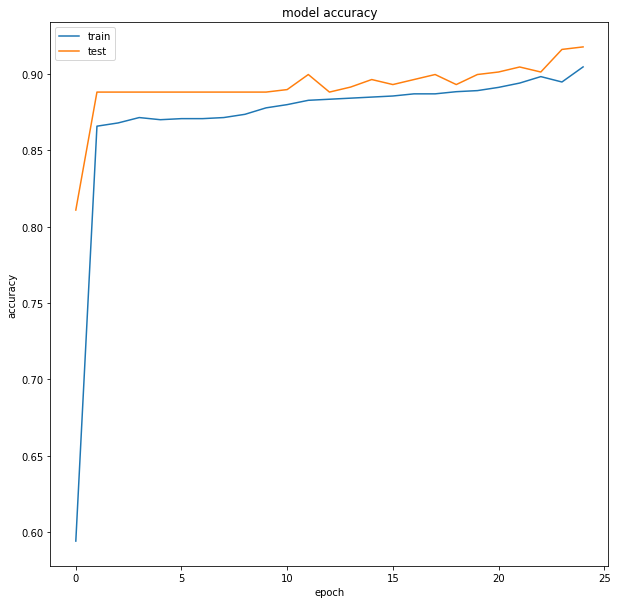

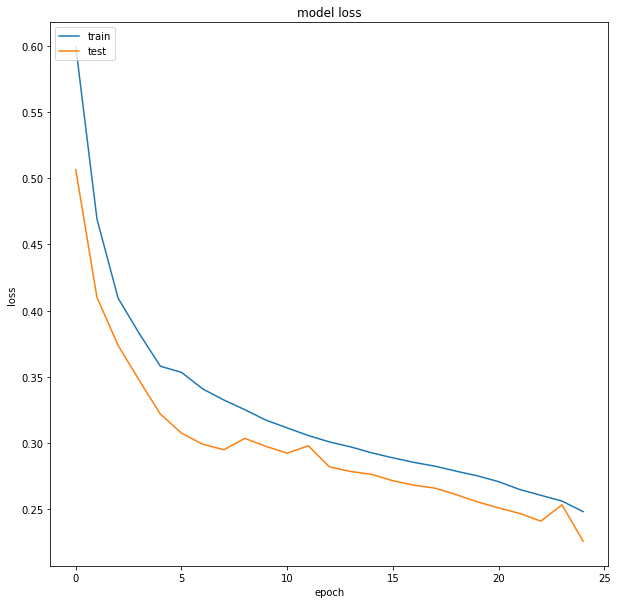

In [ ]:
lstm_test_evaluation_graphs(history_def)

In [ ]:
y_pred=model.predict(X_test)

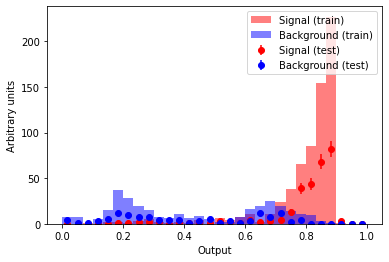

In [ ]:
y_test = reduce_Y(y_test)
y_train = reduce_Y(y_train)
d0 = model.predict(X_train[np.where(y_train>0.5)])
d1 = model.predict(X_train[np.where(y_train<0.5)])

d2 = model.predict(X_test[np.where(y_test>0.5)])
d3 = model.predict(X_test[np.where(y_test<0.5)])

fig, ax = plt.subplots()
ax.hist(d0, color='r', alpha=0.5, range=(0,1), bins=30, histtype='stepfilled', label='Signal (t\
rain)')
ax.hist(d1, color='b', alpha=0.5, range=(0,1), bins=30, histtype='stepfilled', label='Backgroun\
d (train)')
hist, bins = np.histogram(d2, bins=30, range=(0,1))
scale = len(d2) / sum(hist)
err = np.sqrt(hist * scale) / scale
center = (bins[:-1] + bins[1:]) / 2
ax.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Signal (test)')
hist, bins = np.histogram(d3, bins=30, range=(0,1))
scale = len(d3) / sum(hist)
err = np.sqrt(hist * scale) / scale
ax.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Background (test)')
ax.set_xlabel("Output")
ax.set_ylabel("Arbitrary units")
# ax.set_title()
ax.legend(loc='best')

Curva ROC

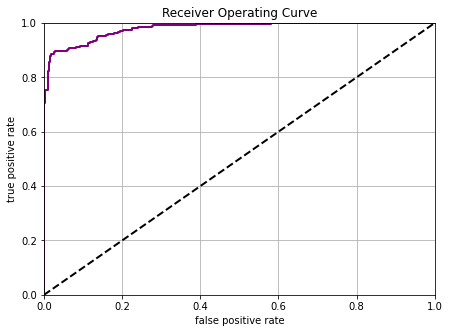

In [ ]:
from sklearn.metrics import roc_curve, auc

# Roc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr,tpr)

# Roc plot
fig_roc, ax_roc = plt.subplots(figsize=(7, 5))
ax_roc.plot(fpr, tpr, lw=2, color='purple',label='full training (auc = %.3f)' % (roc_auc))
ax_roc.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
ax_roc.set_xlim([0, 1.0])
ax_roc.set_ylim([0, 1.0])
ax_roc.set_xlabel('false positive rate')
ax_roc.set_ylabel('true positive rate')
ax_roc.set_title('Receiver Operating Curve')
ax_roc.grid(True)
